In [73]:
from numpy.linalg import inv
from scipy import misc

import warnings
from sklearn.exceptions import ConvergenceWarning

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import sklearn.preprocessing

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

###########
# import our libraries
from blue_conduit_spatial.utilities import build_datasets
from blue_conduit_spatial.evaluation import *

########### set random state
np.random.seed(297)

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62


In [115]:
# this is kinda slow

Xtrain, Xtest, Ytrain, Ytest = build_datasets('../data/flint_sl_materials')

n_train = 1000
n_train_ensemble = 30
n_test_small = 200
n_test_small_ensemble = 100

train_sample_idx = [np.random.choice(np.arange(Xtrain.shape[0]),size=n_train) for i in range(n_train_ensemble)]
features = ['Latitude', 'Longitude']

Xtrains = [Xtrain[features].values[tsi,:] for tsi in train_sample_idx]
Xtest = Xtest[features].values
Ytrains = [Ytrain[['dangerous']].values[tsi].astype(int).flatten() for tsi in train_sample_idx]
Ytest = Ytest[['dangerous']].values.astype(int).flatten()

test_small_idx = [np.random.choice(np.arange(Xtest.shape[0]), size=n_test_small) for i in range(n_test_small_ensemble)]
Xtests_small, Ytests_small = [Xtest[tsi,:] for tsi in test_small_idx], [Ytest[tsi] for tsi in test_small_idx]

Xtrains[0].shape, Ytrains[0].shape, Xtest.shape, Ytest.shape, Xtests_small[0].shape, Ytests_small[0].shape

((1000, 2), (1000,), (6778, 2), (6778,), (200, 2), (200,))

# Is there a problem with any of the lat/lon data?

(2000, 2)
(1999, 2)


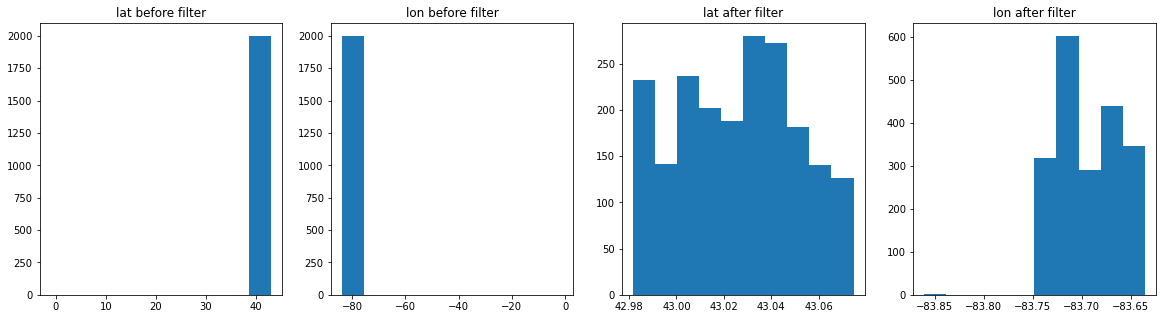

In [47]:
x = Xtrains[0]
print(x.shape)
x_ = x[x[:,0]>42]
x_ = x_[x_[:,0] < 44]
x_ = x_[x_[:,1] > -84]
x_ = x_[x_[:,1] < -83]
print(x_.shape)

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].hist(x[:,0])
ax[0].set_title('lat before filter')
ax[1].hist(x[:,1])
ax[1].set_title('lon before filter')

ax[2].hist(x_[:,0])
ax[2].set_title('lat after filter')
ax[3].hist(x_[:,1])
ax[3].set_title('lon after filter')
plt.show()

(array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.775e+03]),
 array([-1.       ,  3.4075902,  7.8151804, 12.2227706, 16.6303608,
        21.037951 , 25.4455412, 29.8531314, 34.2607216, 38.6683118,
        43.075902 ]),
 <BarContainer object of 10 artists>)

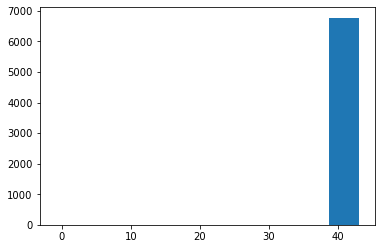

In [20]:
plt.hist(Xtest.Latitude)

# welp

# create a mesh to plot in

In [53]:
def plot_model(fig, ax, model, X, y, title):
    
    # setup mesh
    x1v, x2v = np.meshgrid(np.linspace(LAT_MIN, LAT_MAX,100), np.linspace(LON_MIN, LON_MAX,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]

    # predict on the mesh
    ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)    
    colormesh = ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto')
    fig.colorbar(colormesh, ax=ax)
    
    # plot data
    dangerous_indices = [i for i in range(len(y)) if y[i]==1]
    safe_indices = [i for i in range(len(y)) if y[i]==0]
    ax.scatter(X[dangerous_indices,0], X[dangerous_indices,1], marker= 'x', s=200)
    ax.scatter(X[safe_indices,0], X[safe_indices,1], marker= 'o', s=200, alpha=.1)
    
    # decision boundary of 0.5
    cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
    ax.clabel(cs, fontsize=20)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(LAT_MIN, LAT_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    ax.set_title(title)
    

In [37]:
anisotropic_rbf_kernel = 1.0 * RBF([1.0, 1.0])

def plot_random_state_grid(nrows=3, ncols=3, kernel=anisotropic_rbf_kernel, suptitle='Anisotropic RBF kernel'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

    random_states = [97+i*100 for i in range(nrows*ncols)]
    for i, r in enumerate(random_states):
        ax = axes[i//ncols, i%ncols]
        x_train, x_test, y_train, y_test = get_train_test(data, 200, random_state=r)
        model = GaussianProcessClassifier(kernel=kernel).fit(x_train,y_train)
        plot_model(fig, ax, model, x_train, y_train, title = f'random state {r}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()
    
# plot_random_state_grid()

In [38]:
def get_hyperparameter_options(nrows, ncols, l_range=[1e-3,3e-3], sigma_range=[1e-8,1e-2]):
    # interpolates linearly between the given min and max for l and sigma
    # using nrows and ncols to determine the number of steps
    l_min, l_max = l_range
    sigma_min, sigma_max = sigma_range
    
    l_options = np.array([[l_min*(l_max/l_min)**(i/(ncols-1))]*2 for i in range(ncols)])
    sigma_options = [sigma_min*(sigma_max/sigma_min)**(i/(nrows-1)) for i in range(nrows)]
    
    hyper_options = [{'sigma' : s, 'l' : l} for s in sigma_options for l in l_options]
    return hyper_options

In [39]:

def plot_kernel_grid(nrows=3, ncols=3, suptitle='Changing kernel hyperparameters'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))
    
    x_train, x_test, y_train, y_test = get_train_test(data, 300, random_state=297)
    
    for i, hyper in enumerate(get_hyperparameter_options(nrows, ncols)):
        s, l = hyper['sigma'], hyper['l']
        ax = axes[i//ncols, i%ncols]
        model = GaussianProcessClassifier(kernel= s*RBF(l)).fit(x_train,y_train)
        plot_model(fig, ax, model, x_train, y_train, title = f'random state 297\n sigma={np.round(s,8)}, l={np.round(l[0],5)}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=ConvergenceWarning)
#     plot_kernel_grid(nrows=8, ncols=8)


# cross validation to try different sklearn GP kernels

In [40]:
def gp_kernel_cross_validation():

    x_train, x_test, y_train, y_test = get_train_test(data, 200, 297)

    model = GaussianProcessClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
    # define search
    search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(x_train, y_train)
    
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print("mean test accuracy %.3f with: %r" % (mean, param))
        
#gp_kernel_cross_validation()

In [41]:
matern_kernel = 1.0*Matern(length_scale=1,nu=1.5)
#plot_random_state_grid(kernel = matern_kernel, suptitle='Matern kernel')

# comparing with jared model

(6778,) (6778,)


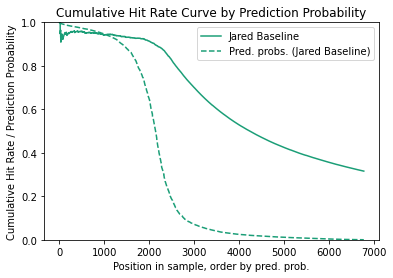

In [44]:
jared_train_pred = pd.read_csv('../data/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv('../data/jared_test_yhat.csv').values
jared_small_train_pred = pd.read_csv('../data/jared_train_yhat_small_train.csv').values
jared_small_test_pred = pd.read_csv('../data/jared_test_yhat_small_train.csv').values
print(Ytest.shape, jared_test_pred[:,1].shape)
plot_hit_rate_curve(Ytest, jared_test_pred[:,1], labels=['Jared Baseline'])

In [116]:
def train_n_models(n):
    
    # model hyperparameters
    sigma = 1e-3
    l = 1e-3
    kernel = sigma*RBF(l)
    
    model_results = {}
    
    for i in range(n):
        
        print(i)
        
        train_d = {}
        test_d = {}

        # choose train and test sample
        # NOTE: using Xtest, Ytest (capital letters) to refer to the main test set of 6,778 homes
        # using xtest, ytest to refer to smaller test sets of 200 homes each (easier for plotting)
        xtrain, ytrain = Xtrains[i], Ytrains[i]

        # fit model
        new_model = GaussianProcessClassifier(kernel=kernel).fit(xtrain,ytrain)

        # predict
        ytrainpred = new_model.predict(xtrain)
        ytrainpred_proba = new_model.predict_proba(xtrain)
        Ytestpred = new_model.predict(Xtest)
        Ytestpred_proba = new_model.predict_proba(Xtest)
        train_d['pred'] = ytrainpred
        test_d['pred'] = Ytestpred

        # calculate metrics
        train_accuracy = accuracy_score(ytrain, ytrainpred)
        test_accuracy = accuracy_score(Ytest, Ytestpred)
        train_precision = precision_score(ytrain, ytrainpred)
        test_precision = precision_score(Ytest, Ytestpred)
        train_recall = recall_score(ytrain, ytrainpred)
        test_recall = recall_score(Ytest, Ytestpred)
        train_auc = roc_auc_score(ytrain, ytrainpred_proba)
        test_auc = roc_auc_score(Ytest, Ytestpred_proba)


        train_d['accuracy'] = train_accuracy
        test_d['accuracy'] = test_accuracy
        train_d['precision'] = train_precision
        test_d['precision'] = test_precision
        train_d['recall'] = train_recall
        test_d['recall'] = test_recall
        train_d['auc'] = train_auc
        test_d['auc'] = test_auc
        
        # only add results if good enough
        if test_auc > 0.7:
            model_results[i] = {'model' : new_model, 'train' : train_d, 'test' : test_d}
    
    return model_results

model_results = train_n_models(30)

0
1
2


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3
4
5
6
7
8
9
10
11


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


12
13
14
15
16


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:428: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


18
19
20
21
22
23
24
25
26
27
28
29


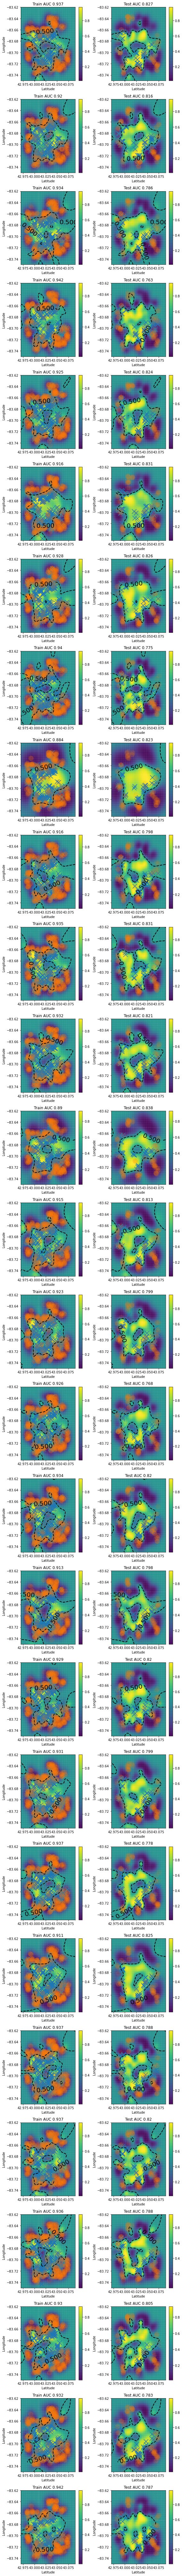

In [117]:
def plot_model_results(model_results):

    nrows = len(model_results.keys())
    fig, axes = plt.subplots(nrows, 2, figsize=(8, 4*nrows))

    for i, key in enumerate(model_results):
        res = model_results[key]
        new_model = res['model']
        train_title = ('Train AUC ') + str(np.round(res['train']['auc'], 3))
        test_title = ('Test AUC ') + str(np.round(res['test']['auc'], 3))

        # plot predictions
        plot_model(fig, axes[i,0], new_model, Xtrains[i], Ytrains[i], train_title)
        plot_model(fig, axes[i,1], new_model, Xtests_small[i], Ytests_small[i], test_title)


    plt.tight_layout()
    plt.show()

plot_model_results(model_results) 


In [137]:
def plot_ensemble(model_results):
    
    n_models = len(model_results)
    
    fig, ax = plt.subplots(figsize = (10,10))
    
    # setup mesh
    x1v, x2v = np.meshgrid(np.linspace(LAT_MIN, LAT_MAX,100), np.linspace(LON_MIN, LON_MAX,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]
    
    ygrid_prob_total = 0

    # predict on the mesh
    for key in model_results:
        model = model_results[key]['model']
        ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape) 
        ygrid_prob_total += (1/n_models) * ygrid_prob
    colormesh = ax.pcolormesh(x1v, x2v, ygrid_prob_total,alpha = 0.8, shading='auto')
    fig.colorbar(colormesh, ax=ax)
    
    # decision boundary of 0.5
    cs = ax.contour(x1v, x2v, ygrid_prob_total, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
    ax.clabel(cs, fontsize=20)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(LAT_MIN, LAT_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    ax.set_title(f'Average of ensemble of {n_models} models')
    
    plt.show()

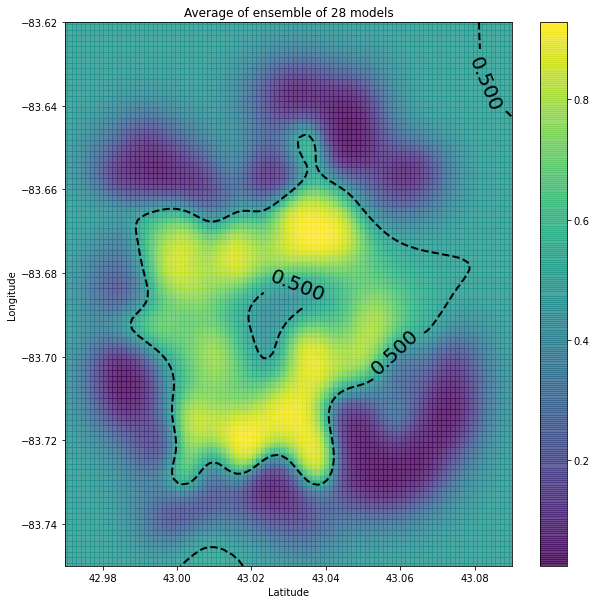

In [138]:
plot_ensemble(model_results)